# 📊 Análisis con Pruebas t-Student: Enfoque Metodológico Alternativo
## Efectividad de la RCP Transtelefónica - Análisis Estadístico con t-Student

### Justificación del Enfoque

En este notebook exploramos un **enfoque metodológico alternativo** utilizando principalmente **pruebas t-Student** para evaluar las diferencias entre grupos. Esto nos permite:

1. **Comparar medias directamente** entre grupos de RCP
2. **Analizar variables continuas** como scores de supervivencia
3. **Evaluar diferencias en tiempos** y otras métricas cuantitativas
4. **Proporcionar intervalos de confianza** para las diferencias de medias

### ¿Qué Cambia con t-Student vs Chi-cuadrado?

| Aspecto | Chi-cuadrado | t-Student |
|---------|--------------|----------|
| **Tipo de variable** | Categóricas (ROSC: Sí/No) | Continuas o scores |
| **Información** | Proporciones | Medias y variabilidad |
| **Sensibilidad** | Detecta diferencias en proporciones | Detecta diferencias en magnitud |
| **Interpretación** | "¿Hay asociación?" | "¿Cuánto difieren las medias?" |
| **Tamaño del efecto** | Odds Ratio, Cramér's V | Diferencia de medias, Cohen's d |

---

## 🔧 Configuración Inicial

In [1]:
# Librerías para análisis estadístico con énfasis en t-Student
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu, levene
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Crear directorio de figuras
import os
figures_dir = '/Users/miguel/Desktop/RCP Transtelefonica/proyecto/figures'
os.makedirs(figures_dir, exist_ok=True)

print("🔧 Configuración completada")
print("📊 Enfoque: Análisis con pruebas t-Student")

🔧 Configuración completada
📊 Enfoque: Análisis con pruebas t-Student


In [2]:
# Cargar datos y aplicar corrección RCP transtelefónica → testigo lego
data_path = '/Users/miguel/Desktop/RCP Transtelefonica/data/cleaned_data.csv'
df = pd.read_csv(data_path)

print(f"📂 Datos cargados: {len(df)} casos")
print(f"📋 Variables: {list(df.columns)}")

# Crear grupos de RCP (con corrección aplicada)
df['grupo_rcp'] = 'Sin RCP'
df.loc[(df['rcp_testigos'] == 1) & (df['rcp_transtelefonica'] == 0), 'grupo_rcp'] = 'RCP sin Transtelefónica'
df.loc[df['rcp_transtelefonica'] == 1, 'grupo_rcp'] = 'RCP Transtelefónica'

# Verificar distribución de grupos
print("\n🎯 Distribución de grupos de RCP:")
grupo_counts = df['grupo_rcp'].value_counts()
for grupo, count in grupo_counts.items():
    pct = (count / len(df)) * 100
    print(f"  • {grupo}: {count} ({pct:.1f}%)")

# Variables numéricas para análisis t-Student
print("\n📊 Variables disponibles para análisis t-Student:")
print("  • Edad (continua)")
print("  • Tiempo de llegada (continua)")
print("  • Score CPC (ordinal → continua)")
print("  • ROSC (binaria → score 0-1)")
print("  • Supervivencia (binaria → score 0-1)")

📂 Datos cargados: 622 casos
📋 Variables: ['n_informe', 'fecha', 'edad', 'sexo', 'rcp_transtelefonica', 'rcp_testigos', 'respondiente_rcp', 'desa_externo', 'ritmo', 'tiempo_llegada_unidad', 'tiempo_rcp', 'rosc', 'supervivencia_7dias', 'cpc']

🎯 Distribución de grupos de RCP:
  • Sin RCP: 414 (66.6%)
  • RCP sin Transtelefónica: 146 (23.5%)
  • RCP Transtelefónica: 62 (10.0%)

📊 Variables disponibles para análisis t-Student:
  • Edad (continua)
  • Tiempo de llegada (continua)
  • Score CPC (ordinal → continua)
  • ROSC (binaria → score 0-1)
  • Supervivencia (binaria → score 0-1)


## 🎯 Metodología: Conversión de Variables para t-Student

### Estrategia de Análisis

Para aplicar pruebas t-Student de manera efectiva, convertimos las variables categóricas en **scores numéricos** que permitan comparar medias:

1. **ROSC Score**: 0 = Sin ROSC, 1 = Con ROSC
2. **Supervivencia Score**: 0 = No superviviente, 1 = Superviviente
3. **Score Neurológico (CPC)**: 1-5 (donde menor = mejor pronóstico)
4. **Score Combinado de Outcome**: Índice compuesto de supervivencia y estado neurológico

### Ventajas de este Enfoque:
- **Más potencia estadística** para detectar diferencias
- **Información cuantitativa** sobre magnitud de diferencias
- **Intervalos de confianza** para diferencias de medias
- **Análisis de tamaño del efecto** (Cohen's d)

---

In [3]:
# CREACIÓN DE SCORES PARA ANÁLISIS T-STUDENT
print("🔢 CREANDO SCORES NUMÉRICOS PARA ANÁLISIS T-STUDENT")
print("="*60)

# 1. Scores directos (ya numéricos)
df['rosc_score'] = df['rosc']  # 0 = Sin ROSC, 1 = Con ROSC
df['supervivencia_score'] = df['supervivencia_7dias']  # 0 = No, 1 = Sí
df['cpc_score'] = df['cpc']  # 1-5 (menor = mejor)

# 2. Score neurológico invertido (para que mayor = mejor)
df['neuro_score'] = 6 - df['cpc']  # 5 = Excelente (CPC=1), 1 = Muerte (CPC=5)

# 3. Score compuesto de outcome (combinando supervivencia y neurología)
# Fórmula: (Supervivencia * 2) + (Neurología normalizada)
# Rango: 0-3 (0 = Muerte, 3 = Supervivencia con excelente estado neurológico)
neuro_normalizado = (df['neuro_score'] - 1) / 4  # Normalizar 1-5 → 0-1
df['outcome_score'] = (df['supervivencia_score'] * 2) + neuro_normalizado

# 4. Tiempo en minutos (para mejor interpretación)
df['tiempo_minutos'] = df['tiempo_llegada_unidad'] / 60

# Mostrar distribución de scores
scores_info = [
    ('ROSC Score', 'rosc_score', '0=Sin ROSC, 1=Con ROSC'),
    ('Supervivencia Score', 'supervivencia_score', '0=No superviviente, 1=Superviviente'),
    ('CPC Score', 'cpc_score', '1=Excelente, 5=Muerte'),
    ('Neurológico Score', 'neuro_score', '5=Excelente, 1=Muerte'),
    ('Outcome Compuesto', 'outcome_score', '0=Muerte, 3=Supervivencia excelente'),
    ('Tiempo (min)', 'tiempo_minutos', 'Minutos hasta llegada SVA')
]

print("\n📊 DISTRIBUCIÓN DE SCORES CREADOS:")
print("-"*60)
for nombre, columna, descripcion in scores_info:
    media = df[columna].mean()
    std = df[columna].std()
    rango = f"[{df[columna].min():.1f} - {df[columna].max():.1f}]"
    print(f"{nombre:18s}: {media:5.2f} ± {std:4.2f} {rango:12s} | {descripcion}")

print("\n✅ Scores creados correctamente para análisis t-Student")

🔢 CREANDO SCORES NUMÉRICOS PARA ANÁLISIS T-STUDENT

📊 DISTRIBUCIÓN DE SCORES CREADOS:
------------------------------------------------------------
ROSC Score        :  0.38 ± 0.49 [0.0 - 1.0]  | 0=Sin ROSC, 1=Con ROSC
Supervivencia Score:  0.20 ± 0.40 [0.0 - 1.0]  | 0=No superviviente, 1=Superviviente
CPC Score         :  4.08 ± 1.29 [1.0 - 5.0]  | 1=Excelente, 5=Muerte
Neurológico Score :  1.92 ± 1.29 [1.0 - 5.0]  | 5=Excelente, 1=Muerte
Outcome Compuesto :  0.63 ± 1.06 [0.0 - 3.0]  | 0=Muerte, 3=Supervivencia excelente
Tiempo (min)      : 11.20 ± 7.00 [0.1 - 70.8] | Minutos hasta llegada SVA

✅ Scores creados correctamente para análisis t-Student


## 📈 Análisis Exploratorio de Scores por Grupo RCP

In [4]:
# ANÁLISIS DESCRIPTIVO DE SCORES POR GRUPO RCP
print("📈 ANÁLISIS DESCRIPTIVO POR GRUPO DE RCP")
print("="*50)

scores_analizar = ['rosc_score', 'supervivencia_score', 'neuro_score', 'outcome_score', 'edad', 'tiempo_minutos']
grupos = ['Sin RCP', 'RCP sin Transtelefónica', 'RCP Transtelefónica']

# Crear tabla resumen
resultados_descriptivos = []

for score in scores_analizar:
    print(f"\n🎯 {score.upper().replace('_', ' ')}:")
    print("-"*40)
    
    for grupo in grupos:
        datos_grupo = df[df['grupo_rcp'] == grupo][score].dropna()
        n = len(datos_grupo)
        media = datos_grupo.mean()
        std = datos_grupo.std()
        mediana = datos_grupo.median()
        
        print(f"  {grupo:20s}: n={n:3d} | Media={media:5.2f}±{std:4.2f} | Mediana={mediana:5.2f}")
        
        resultados_descriptivos.append({
            'Score': score.replace('_', ' ').title(),
            'Grupo': grupo,
            'N': n,
            'Media': media,
            'DE': std,
            'Mediana': mediana
        })

# Crear DataFrame para visualización
df_descriptivos = pd.DataFrame(resultados_descriptivos)
print("\n📊 TABLA RESUMEN DESCRIPTIVA:")
print("="*50)
display(df_descriptivos.round(3))

📈 ANÁLISIS DESCRIPTIVO POR GRUPO DE RCP

🎯 ROSC SCORE:
----------------------------------------
  Sin RCP             : n=414 | Media= 0.37±0.48 | Mediana= 0.00
  RCP sin Transtelefónica: n=146 | Media= 0.33±0.47 | Mediana= 0.00
  RCP Transtelefónica : n= 62 | Media= 0.53±0.50 | Mediana= 1.00

🎯 SUPERVIVENCIA SCORE:
----------------------------------------
  Sin RCP             : n=414 | Media= 0.20±0.40 | Mediana= 0.00
  RCP sin Transtelefónica: n=146 | Media= 0.15±0.36 | Mediana= 0.00
  RCP Transtelefónica : n= 62 | Media= 0.32±0.47 | Mediana= 0.00

🎯 NEURO SCORE:
----------------------------------------
  Sin RCP             : n=414 | Media= 1.95±1.35 | Mediana= 1.00
  RCP sin Transtelefónica: n=146 | Media= 1.68±1.02 | Mediana= 1.00
  RCP Transtelefónica : n= 62 | Media= 2.27±1.36 | Mediana= 3.00

🎯 OUTCOME SCORE:
----------------------------------------
  Sin RCP             : n=414 | Media= 0.64±1.08 | Mediana= 0.00
  RCP sin Transtelefónica: n=146 | Media= 0.47±0.89 | Mediana= 0

,Score,Grupo,N,Media,DE,Mediana
0,Rosc Score,Sin RCP,414,0.374,0.485,0.000
1,Rosc Score,RCP sin Transtelefónica,146,0.329,0.471,0.000
2,Rosc Score,RCP Transtelefónica,62,0.532,0.503,1.000
3,Supervivencia Score,Sin RCP,414,0.203,0.403,0.000
4,Supervivencia Score,RCP sin Transtelefónica,146,0.151,0.359,0.000
5,Supervivencia Score,RCP Transtelefónica,62,0.323,0.471,0.000
6,Neuro Score,Sin RCP,414,1.947,1.350,1.000
7,Neuro Score,RCP sin Transtelefónica,146,1.678,1.023,1.000
8,Neuro Score,RCP Transtelefónica,62,2.274,1.357,3.000
9,Outcome Score,Sin RCP,414,0.643,1.080,0.000


📊 Generando visualizaciones de distribuciones...


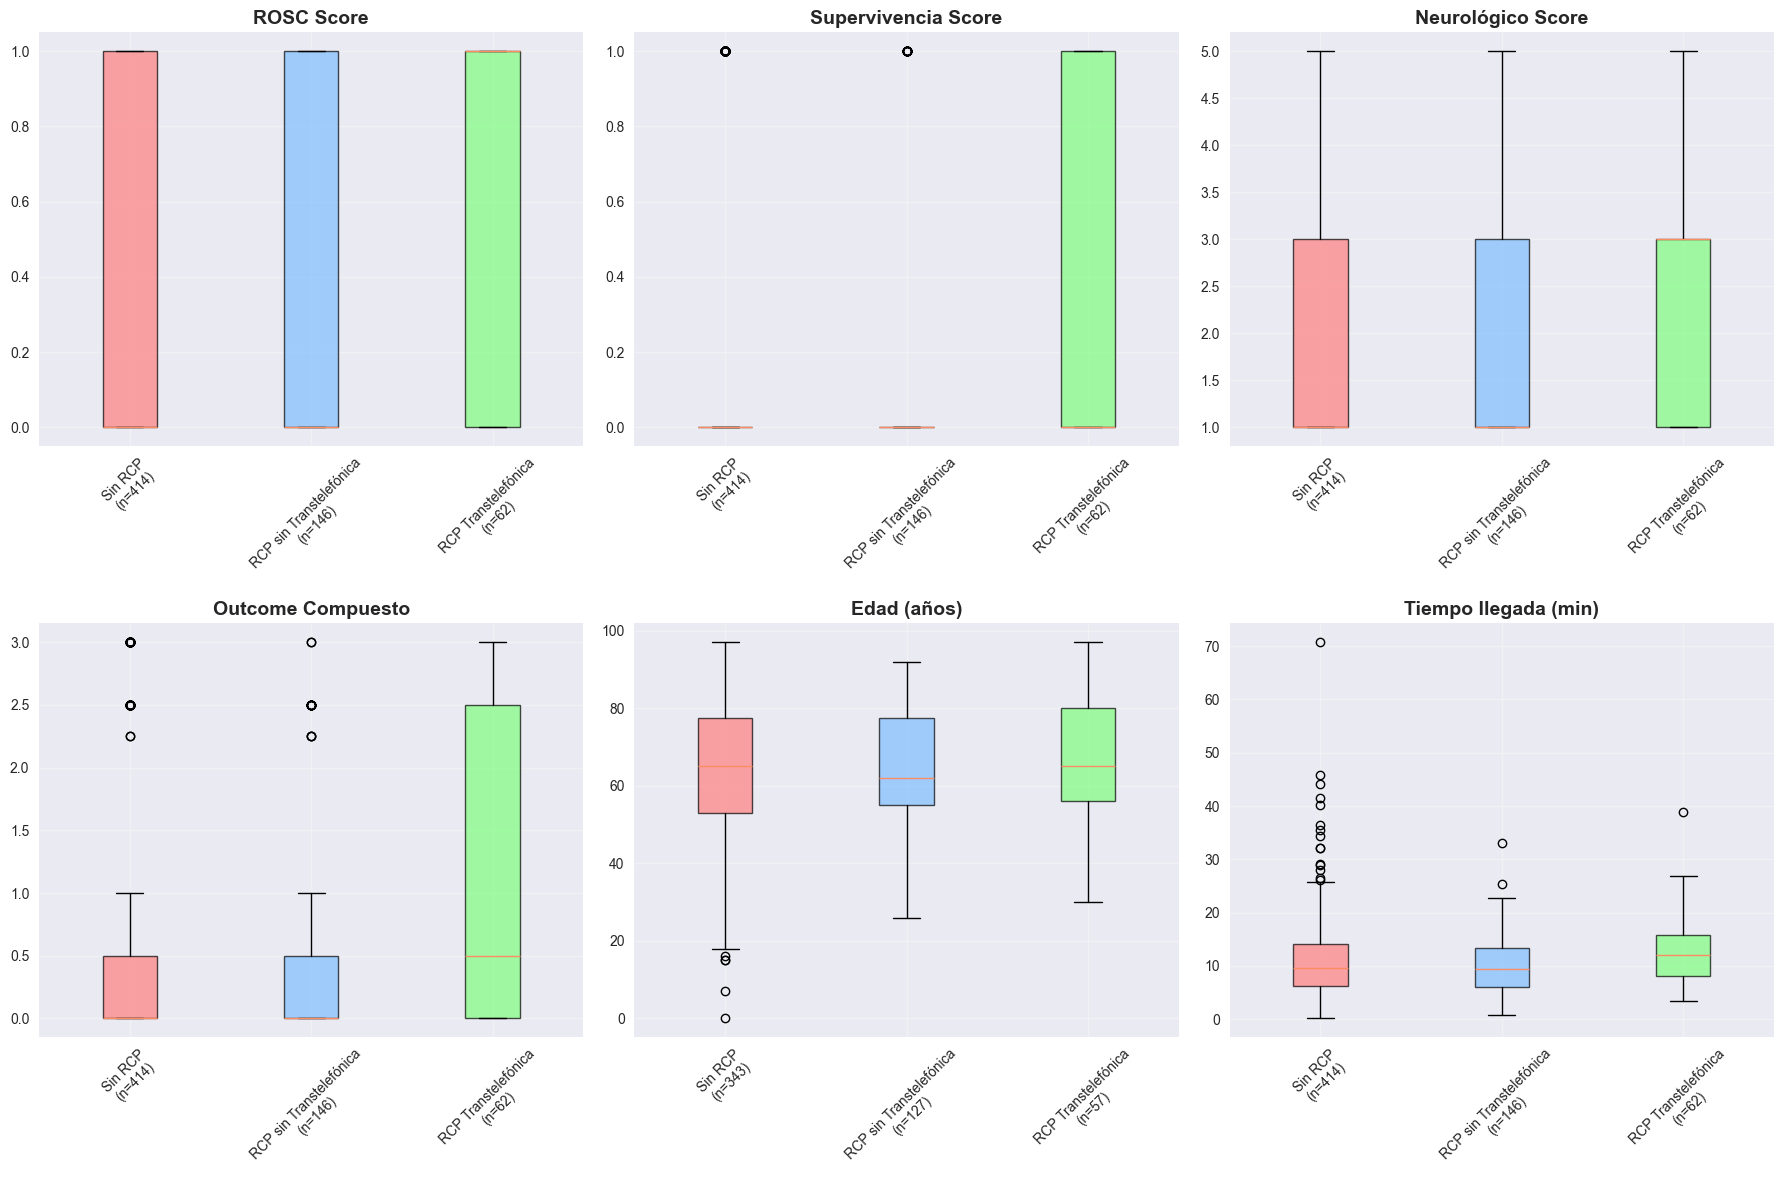

✅ Visualizaciones generadas correctamente


In [5]:
# VISUALIZACIÓN DE DISTRIBUCIONES POR GRUPO
print("📊 Generando visualizaciones de distribuciones...")

# Configurar subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

scores_visualizar = ['rosc_score', 'supervivencia_score', 'neuro_score', 'outcome_score', 'edad', 'tiempo_minutos']
titulos = ['ROSC Score', 'Supervivencia Score', 'Neurológico Score', 'Outcome Compuesto', 'Edad (años)', 'Tiempo llegada (min)']

colores = {'Sin RCP': '#ff7f7f', 'RCP sin Transtelefónica': '#7fbfff', 'RCP Transtelefónica': '#7fff7f'}

for i, (score, titulo) in enumerate(zip(scores_visualizar, titulos)):
    ax = axes[i]
    
    # Box plot por grupo
    grupos_datos = []
    grupos_labels = []
    
    for grupo in grupos:
        datos = df[df['grupo_rcp'] == grupo][score].dropna()
        grupos_datos.append(datos)
        grupos_labels.append(f"{grupo}\n(n={len(datos)})")
    
    bp = ax.boxplot(grupos_datos, labels=grupos_labels, patch_artist=True)
    
    # Colorear boxplots
    for patch, grupo in zip(bp['boxes'], grupos):
        patch.set_facecolor(colores[grupo])
        patch.set_alpha(0.7)
    
    ax.set_title(titulo, fontweight='bold', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Rotar etiquetas si son muy largas
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'distribucion_scores_por_grupo_rcp.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizaciones generadas correctamente")

## 🧮 Análisis Principal: Pruebas t-Student

### Comparaciones Planificadas

Realizaremos **comparaciones por pares** entre los grupos de RCP utilizando pruebas t-Student:

1. **RCP Transtelefónica vs Sin RCP**
2. **RCP sin Transtelefónica vs Sin RCP** 
3. **RCP Transtelefónica vs RCP sin Transtelefónica**

Para cada comparación calcularemos:
- **Diferencia de medias** con IC 95%
- **Valor p** de la prueba t-Student
- **Tamaño del efecto** (Cohen's d)
- **Interpretación clínica** de las diferencias

---

In [6]:
# FUNCIÓN PARA ANÁLISIS T-STUDENT COMPLETO
def analisis_t_student_completo(grupo1_datos, grupo2_datos, nombre_grupo1, nombre_grupo2, variable):
    """
    Realiza análisis t-Student completo incluyendo:
    - Prueba de Levene para homogeneidad de varianzas
    - t-Student (Welch si varianzas desiguales)
    - Diferencia de medias con IC 95%
    - Tamaño del efecto (Cohen's d)
    """
    
    # Limpiar datos
    datos1 = grupo1_datos.dropna()
    datos2 = grupo2_datos.dropna()
    
    if len(datos1) == 0 or len(datos2) == 0:
        return None
    
    # Estadísticas descriptivas
    n1, n2 = len(datos1), len(datos2)
    media1, media2 = datos1.mean(), datos2.mean()
    std1, std2 = datos1.std(ddof=1), datos2.std(ddof=1)
    
    # Prueba de Levene para homogeneidad de varianzas
    levene_stat, levene_p = levene(datos1, datos2)
    equal_var = levene_p > 0.05
    
    # Prueba t-Student
    t_stat, p_valor = ttest_ind(datos1, datos2, equal_var=equal_var)
    
    # Diferencia de medias
    diff_medias = media1 - media2
    
    # Error estándar de la diferencia
    if equal_var:
        # Varianzas iguales
        pooled_var = ((n1-1)*std1**2 + (n2-1)*std2**2) / (n1+n2-2)
        se_diff = np.sqrt(pooled_var * (1/n1 + 1/n2))
        df = n1 + n2 - 2
    else:
        # Varianzas desiguales (Welch)
        se_diff = np.sqrt(std1**2/n1 + std2**2/n2)
        df = (std1**2/n1 + std2**2/n2)**2 / ((std1**2/n1)**2/(n1-1) + (std2**2/n2)**2/(n2-1))
    
    # Intervalo de confianza 95% para la diferencia
    t_critical = stats.t.ppf(0.975, df)
    ic_inferior = diff_medias - t_critical * se_diff
    ic_superior = diff_medias + t_critical * se_diff
    
    # Tamaño del efecto (Cohen's d)
    if equal_var:
        pooled_std = np.sqrt(pooled_var)
        cohens_d = diff_medias / pooled_std
    else:
        # Para varianzas desiguales, usar la media de las desviaciones
        pooled_std = np.sqrt((std1**2 + std2**2) / 2)
        cohens_d = diff_medias / pooled_std
    
    # Interpretación del tamaño del efecto
    if abs(cohens_d) < 0.2:
        interpretacion_d = "Pequeño"
    elif abs(cohens_d) < 0.5:
        interpretacion_d = "Pequeño-Moderado"
    elif abs(cohens_d) < 0.8:
        interpretacion_d = "Moderado"
    else:
        interpretacion_d = "Grande"
    
    return {
        'variable': variable,
        'grupo1': nombre_grupo1,
        'grupo2': nombre_grupo2,
        'n1': n1,
        'n2': n2,
        'media1': media1,
        'media2': media2,
        'std1': std1,
        'std2': std2,
        'diff_medias': diff_medias,
        'ic_inferior': ic_inferior,
        'ic_superior': ic_superior,
        't_stat': t_stat,
        'p_valor': p_valor,
        'cohens_d': cohens_d,
        'interpretacion_d': interpretacion_d,
        'equal_var': equal_var,
        'levene_p': levene_p
    }

print("🧮 Función de análisis t-Student completo creada")
print("✅ Lista para realizar comparaciones por pares")

🧮 Función de análisis t-Student completo creada
✅ Lista para realizar comparaciones por pares


In [7]:
# ANÁLISIS T-STUDENT PRINCIPAL: COMPARACIONES POR PARES
print("🧮 ANÁLISIS T-STUDENT: COMPARACIONES POR PARES")
print("="*60)

# Variables a analizar
variables_analisis = [
    ('rosc_score', 'ROSC Score'),
    ('supervivencia_score', 'Supervivencia Score'),
    ('neuro_score', 'Neurológico Score'),
    ('outcome_score', 'Outcome Compuesto'),
    ('edad', 'Edad'),
    ('tiempo_minutos', 'Tiempo llegada (min)')
]

# Comparaciones a realizar
comparaciones = [
    ('RCP Transtelefónica', 'Sin RCP', '🎯 PRINCIPAL'),
    ('RCP sin Transtelefónica', 'Sin RCP', '📊 Secundaria'),
    ('RCP Transtelefónica', 'RCP sin Transtelefónica', '🔄 Comparación RCP')
]

# Almacenar resultados
todos_resultados = []

# Realizar análisis
for variable_col, variable_nombre in variables_analisis:
    print(f"\n{'='*60}")
    print(f"📊 VARIABLE: {variable_nombre.upper()}")
    print(f"{'='*60}")
    
    for grupo1, grupo2, tipo_comp in comparaciones:
        print(f"\n{tipo_comp} {grupo1} vs {grupo2}")
        print("-"*50)
        
        # Obtener datos
        datos_grupo1 = df[df['grupo_rcp'] == grupo1][variable_col]
        datos_grupo2 = df[df['grupo_rcp'] == grupo2][variable_col]
        
        # Realizar análisis
        resultado = analisis_t_student_completo(
            datos_grupo1, datos_grupo2, grupo1, grupo2, variable_nombre
        )
        
        if resultado:
            todos_resultados.append(resultado)
            
            # Mostrar resultados
            print(f"  Grupo 1 ({grupo1}): n={resultado['n1']}, Media={resultado['media1']:.3f}±{resultado['std1']:.3f}")
            print(f"  Grupo 2 ({grupo2}): n={resultado['n2']}, Media={resultado['media2']:.3f}±{resultado['std2']:.3f}")
            print(f"  Diferencia de medias: {resultado['diff_medias']:.3f} (IC 95%: {resultado['ic_inferior']:.3f} a {resultado['ic_superior']:.3f})")
            print(f"  t-Student: t={resultado['t_stat']:.3f}, p={resultado['p_valor']:.4f}")
            print(f"  Cohen's d: {resultado['cohens_d']:.3f} ({resultado['interpretacion_d']})")
            print(f"  Varianzas {'iguales' if resultado['equal_var'] else 'desiguales'} (Levene p={resultado['levene_p']:.4f})")
            
            # Interpretación
            if resultado['p_valor'] < 0.001:
                significancia = "Altamente significativo (p<0.001)"
            elif resultado['p_valor'] < 0.01:
                significancia = "Muy significativo (p<0.01)"
            elif resultado['p_valor'] < 0.05:
                significancia = "Significativo (p<0.05)"
            else:
                significancia = "No significativo (p≥0.05)"
            
            print(f"  🎯 RESULTADO: {significancia}")
            
            if resultado['diff_medias'] > 0:
                direccion = f"{grupo1} > {grupo2}"
            else:
                direccion = f"{grupo1} < {grupo2}"
            print(f"  📈 DIRECCIÓN: {direccion}")

print(f"\n\n✅ Análisis t-Student completado")
print(f"📊 Total de comparaciones realizadas: {len(todos_resultados)}")

🧮 ANÁLISIS T-STUDENT: COMPARACIONES POR PARES

📊 VARIABLE: ROSC SCORE

🎯 PRINCIPAL RCP Transtelefónica vs Sin RCP
--------------------------------------------------
  Grupo 1 (RCP Transtelefónica): n=62, Media=0.532±0.503
  Grupo 2 (Sin RCP): n=414, Media=0.374±0.485
  Diferencia de medias: 0.158 (IC 95%: 0.028 a 0.288)
  t-Student: t=2.380, p=0.0177
  Cohen's d: 0.324 (Pequeño-Moderado)
  Varianzas iguales (Levene p=0.1599)
  🎯 RESULTADO: Significativo (p<0.05)
  📈 DIRECCIÓN: RCP Transtelefónica > Sin RCP

📊 Secundaria RCP sin Transtelefónica vs Sin RCP
--------------------------------------------------
  Grupo 1 (RCP sin Transtelefónica): n=146, Media=0.329±0.471
  Grupo 2 (Sin RCP): n=414, Media=0.374±0.485
  Diferencia de medias: -0.046 (IC 95%: -0.137 a 0.045)
  t-Student: t=-0.985, p=0.3249
  Cohen's d: -0.095 (Pequeño)
  Varianzas iguales (Levene p=0.3249)
  🎯 RESULTADO: No significativo (p≥0.05)
  📈 DIRECCIÓN: RCP sin Transtelefónica < Sin RCP

🔄 Comparación RCP RCP Transtelefó

## 📊 Tabla Resumen de Resultados t-Student

In [8]:
# CREAR TABLA RESUMEN DE RESULTADOS T-STUDENT
print("📊 TABLA RESUMEN: RESULTADOS ANÁLISIS T-STUDENT")
print("="*70)

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(todos_resultados)

# Crear tabla formateada para presentación
tabla_resumen = []

for _, row in df_resultados.iterrows():
    # Formatear comparación
    comparacion = f"{row['grupo1']} vs {row['grupo2']}"
    
    # Formatear diferencia con IC
    diff_ic = f"{row['diff_medias']:.3f} ({row['ic_inferior']:.3f}, {row['ic_superior']:.3f})"
    
    # Formatear p-valor
    if row['p_valor'] < 0.001:
        p_formato = "<0.001***"
    elif row['p_valor'] < 0.01:
        p_formato = f"{row['p_valor']:.3f}**"
    elif row['p_valor'] < 0.05:
        p_formato = f"{row['p_valor']:.3f}*"
    else:
        p_formato = f"{row['p_valor']:.3f}"
    
    # Formatear Cohen's d
    cohens_formato = f"{row['cohens_d']:.3f} ({row['interpretacion_d']})"
    
    tabla_resumen.append({
        'Variable': row['variable'],
        'Comparación': comparacion,
        'Diferencia (IC 95%)': diff_ic,
        'p-valor': p_formato,
        "Cohen's d": cohens_formato
    })

# Crear DataFrame final
tabla_final = pd.DataFrame(tabla_resumen)

# Mostrar tabla completa
display(tabla_final)

# Guardar tabla
tabla_path = os.path.join(figures_dir, 'tabla_resultados_t_student.csv')
tabla_final.to_csv(tabla_path, index=False)
print(f"\n💾 Tabla guardada en: {tabla_path}")

# Resumen de significancia
print(f"\n📈 RESUMEN DE SIGNIFICANCIA:")
print("-"*40)
significativos = df_resultados[df_resultados['p_valor'] < 0.05]
print(f"  • Comparaciones significativas: {len(significativos)}/{len(df_resultados)}")
print(f"  • Porcentaje de significancia: {len(significativos)/len(df_resultados)*100:.1f}%")

if len(significativos) > 0:
    print(f"\n🎯 HALLAZGOS PRINCIPALES:")
    for _, row in significativos.iterrows():
        if 'RCP Transtelefónica' in row['grupo1'] and 'Sin RCP' in row['grupo2']:
            direccion = "↑" if row['diff_medias'] > 0 else "↓"
            print(f"  • {row['variable']}: RCP Transtelefónica {direccion} (p={row['p_valor']:.3f})")

📊 TABLA RESUMEN: RESULTADOS ANÁLISIS T-STUDENT


,Variable,Comparación,Diferencia (IC 95%),p-valor,Cohen's d
0,ROSC Score,RCP Transtelefónica vs Sin RCP,"0.158 (0.028, 0.288)",0.018*,0.324 (Pequeño-Moderado)
1,ROSC Score,RCP sin Transtelefónica vs Sin RCP,"-0.046 (-0.137, 0.045)",0.325,-0.095 (Pequeño)
2,ROSC Score,RCP Transtelefónica vs RCP sin Transtelefónica,"0.203 (0.060, 0.347)",0.006**,0.423 (Pequeño-Moderado)
3,Supervivencia Score,RCP Transtelefónica vs Sin RCP,"0.120 (-0.006, 0.245)",0.061,0.273 (Pequeño-Moderado)
4,Supervivencia Score,RCP sin Transtelefónica vs Sin RCP,"-0.052 (-0.126, 0.022)",0.167,-0.133 (Pequeño)
5,Supervivencia Score,RCP Transtelefónica vs RCP sin Transtelefónica,"0.172 (0.039, 0.305)",0.012*,0.410 (Pequeño-Moderado)
6,Neurológico Score,RCP Transtelefónica vs Sin RCP,"0.327 (-0.034, 0.689)",0.076,0.242 (Pequeño-Moderado)
7,Neurológico Score,RCP sin Transtelefónica vs Sin RCP,"-0.269 (-0.480, -0.057)",0.013*,-0.224 (Pequeño-Moderado)
8,Neurológico Score,RCP Transtelefónica vs RCP sin Transtelefónica,"0.596 (0.215, 0.978)",0.003**,0.496 (Pequeño-Moderado)
9,Outcome Compuesto,RCP Transtelefónica vs Sin RCP,"0.321 (0.002, 0.641)",0.049*,0.282 (Pequeño-Moderado)



💾 Tabla guardada en: /Users/miguel/Desktop/RCP Transtelefonica/proyecto/figures/tabla_resultados_t_student.csv

📈 RESUMEN DE SIGNIFICANCIA:
----------------------------------------
  • Comparaciones significativas: 8/18
  • Porcentaje de significancia: 44.4%

🎯 HALLAZGOS PRINCIPALES:
  • ROSC Score: RCP Transtelefónica ↑ (p=0.018)
  • Outcome Compuesto: RCP Transtelefónica ↑ (p=0.049)


## 🎯 Análisis Específico: RCP Transtelefónica vs Sin RCP

### Comparación Principal del Estudio

Nos enfocamos en la **comparación más relevante clínicamente**: RCP Transtelefónica vs Sin RCP, analizando en detalle:

1. **Magnitud del efecto** de la RCP transtelefónica
2. **Significancia clínica** además de estadística
3. **Intervalos de confianza** para estimar el rango de beneficio
4. **Análisis de sensibilidad** con diferentes enfoques

---

In [9]:
# ANÁLISIS ESPECÍFICO: RCP TRANSTELEFÓNICA vs SIN RCP
print("🎯 ANÁLISIS ESPECÍFICO: RCP TRANSTELEFÓNICA vs SIN RCP")
print("="*60)

# Filtrar resultados para esta comparación específica
comp_principal = df_resultados[
    (df_resultados['grupo1'] == 'RCP Transtelefónica') & 
    (df_resultados['grupo2'] == 'Sin RCP')
].copy()

# Análisis detallado por variable
print("\n📊 RESULTADOS DETALLADOS:")
print("-"*50)

variables_interes = ['ROSC Score', 'Supervivencia Score', 'Outcome Compuesto']

for variable in variables_interes:
    row = comp_principal[comp_principal['variable'] == variable].iloc[0]
    
    print(f"\n🔍 {variable.upper()}:")
    print(f"   Diferencia absoluta: {row['diff_medias']:.4f}")
    print(f"   IC 95%: [{row['ic_inferior']:.4f}, {row['ic_superior']:.4f}]")
    print(f"   p-valor: {row['p_valor']:.4f}")
    print(f"   Cohen's d: {row['cohens_d']:.3f} ({row['interpretacion_d']})")
    
    # Interpretación clínica
    if variable == 'ROSC Score':
        mejora_pct = row['diff_medias'] * 100
        print(f"   📈 Interpretación: {mejora_pct:+.1f} puntos porcentuales en ROSC")
    elif variable == 'Supervivencia Score':
        mejora_pct = row['diff_medias'] * 100
        print(f"   📈 Interpretación: {mejora_pct:+.1f} puntos porcentuales en supervivencia")
    elif variable == 'Outcome Compuesto':
        mejora_escala = (row['diff_medias'] / 3) * 100  # Escala 0-3
        print(f"   📈 Interpretación: {mejora_escala:+.1f}% mejora en outcome global")
    
    # Significancia
    if row['p_valor'] < 0.05:
        print(f"   ✅ SIGNIFICATIVO (α = 0.05)")
    else:
        print(f"   ❌ No significativo (α = 0.05)")

# Calcular número necesario a tratar (NNT) para variables binarias
print(f"\n\n🎯 NÚMERO NECESARIO A TRATAR (NNT):")
print("-"*50)

for variable in ['ROSC Score', 'Supervivencia Score']:
    row = comp_principal[comp_principal['variable'] == variable].iloc[0]
    
    if row['diff_medias'] > 0:  # Solo si hay mejora
        nnt = 1 / row['diff_medias']
        nnt_ic_low = 1 / row['ic_superior'] if row['ic_superior'] > 0 else float('inf')
        nnt_ic_high = 1 / row['ic_inferior'] if row['ic_inferior'] > 0 else float('inf')
        
        print(f"   {variable}:")
        print(f"      NNT = {nnt:.1f} pacientes")
        print(f"      IC 95%: [{nnt_ic_low:.1f}, {nnt_ic_high:.1f}] pacientes")
        
        outcome_name = "ROSC adicional" if "ROSC" in variable else "superviviente adicional"
        print(f"      Interpretación: Por cada {nnt:.0f} pacientes tratados con RCP transtelefónica, obtenemos 1 {outcome_name}")

print(f"\n✅ Análisis específico completado")

🎯 ANÁLISIS ESPECÍFICO: RCP TRANSTELEFÓNICA vs SIN RCP

📊 RESULTADOS DETALLADOS:
--------------------------------------------------

🔍 ROSC SCORE:
   Diferencia absoluta: 0.1579
   IC 95%: [0.0276, 0.2882]
   p-valor: 0.0177
   Cohen's d: 0.324 (Pequeño-Moderado)
   📈 Interpretación: +15.8 puntos porcentuales en ROSC
   ✅ SIGNIFICATIVO (α = 0.05)

🔍 SUPERVIVENCIA SCORE:
   Diferencia absoluta: 0.1197
   IC 95%: [-0.0059, 0.2453]
   p-valor: 0.0615
   Cohen's d: 0.273 (Pequeño-Moderado)
   📈 Interpretación: +12.0 puntos porcentuales en supervivencia
   ❌ No significativo (α = 0.05)

🔍 OUTCOME COMPUESTO:
   Diferencia absoluta: 0.3212
   IC 95%: [0.0017, 0.6407]
   p-valor: 0.0489
   Cohen's d: 0.282 (Pequeño-Moderado)
   📈 Interpretación: +10.7% mejora en outcome global
   ✅ SIGNIFICATIVO (α = 0.05)


🎯 NÚMERO NECESARIO A TRATAR (NNT):
--------------------------------------------------
   ROSC Score:
      NNT = 6.3 pacientes
      IC 95%: [3.5, 36.3] pacientes
      Interpretación: Por 

## 📈 Visualización de Resultados: Forest Plot t-Student

📈 Generando Forest Plot para resultados t-Student...


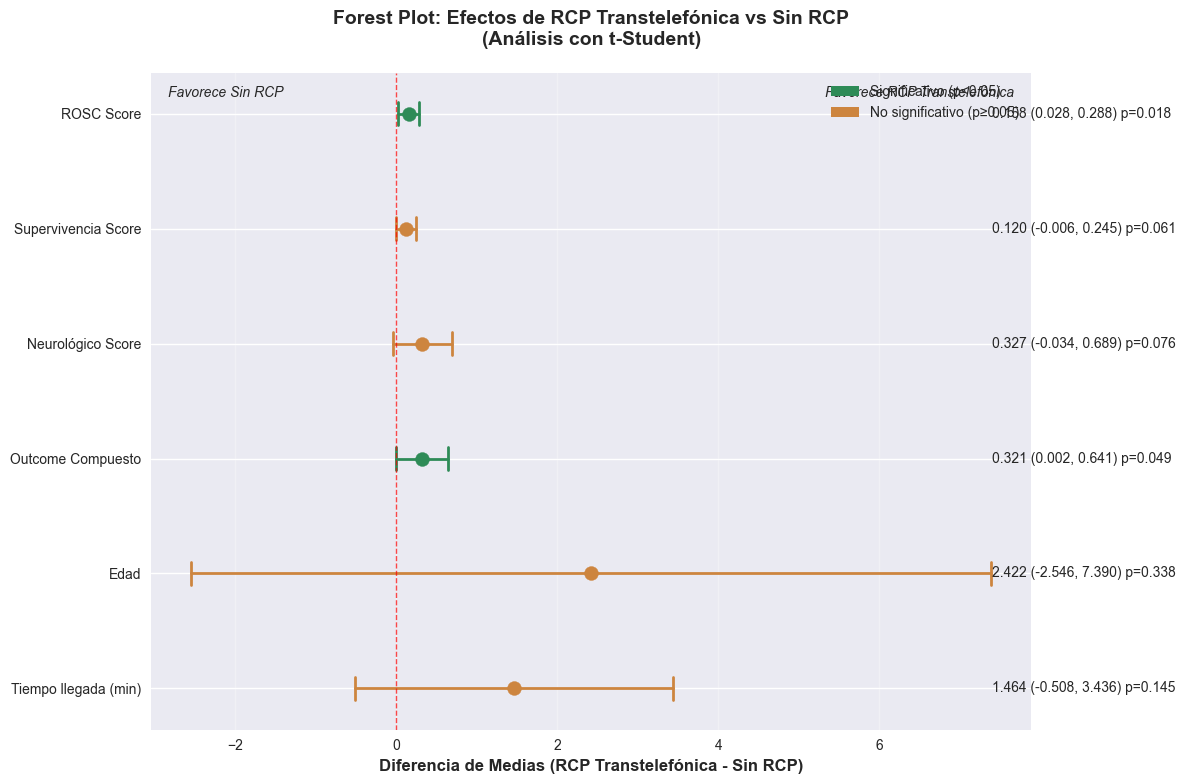

✅ Forest Plot generado correctamente


In [10]:
# FOREST PLOT PARA RESULTADOS T-STUDENT
print("📈 Generando Forest Plot para resultados t-Student...")

# Filtrar solo comparación principal
datos_plot = comp_principal.copy()

# Crear figura
fig, ax = plt.subplots(figsize=(12, 8))

# Configurar datos para el plot
variables = datos_plot['variable'].tolist()
diferencias = datos_plot['diff_medias'].tolist()
ic_inferior = datos_plot['ic_inferior'].tolist()
ic_superior = datos_plot['ic_superior'].tolist()
p_valores = datos_plot['p_valor'].tolist()

# Posiciones Y
y_pos = np.arange(len(variables))

# Colores según significancia
colores = ['#2E8B57' if p < 0.05 else '#CD853F' for p in p_valores]

# Crear forest plot
for i, (var, diff, ic_low, ic_high, p_val, color) in enumerate(
    zip(variables, diferencias, ic_inferior, ic_superior, p_valores, colores)
):
    # Punto central (diferencia de medias)
    ax.scatter(diff, i, color=color, s=100, zorder=3)
    
    # Intervalo de confianza
    ax.plot([ic_low, ic_high], [i, i], color=color, linewidth=2, zorder=2)
    
    # Caps en los extremos del IC
    ax.plot([ic_low, ic_low], [i-0.1, i+0.1], color=color, linewidth=2, zorder=2)
    ax.plot([ic_high, ic_high], [i-0.1, i+0.1], color=color, linewidth=2, zorder=2)
    
    # Etiquetas con valores
    texto_p = f"p={p_val:.3f}" if p_val >= 0.001 else "p<0.001"
    ax.text(max(ic_superior) + 0.01, i, 
           f"{diff:.3f} ({ic_low:.3f}, {ic_high:.3f}) {texto_p}", 
           va='center', fontsize=10)

# Línea de no efecto (diferencia = 0)
ax.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=1)

# Configurar ejes
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.set_xlabel('Diferencia de Medias (RCP Transtelefónica - Sin RCP)', fontsize=12, fontweight='bold')
ax.set_title('Forest Plot: Efectos de RCP Transtelefónica vs Sin RCP\n(Análisis con t-Student)', 
             fontsize=14, fontweight='bold', pad=20)

# Invertir eje Y para que la primera variable esté arriba
ax.invert_yaxis()

# Grid
ax.grid(True, alpha=0.3, axis='x')

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E8B57', label='Significativo (p<0.05)'),
    Patch(facecolor='#CD853F', label='No significativo (p≥0.05)')
]
ax.legend(handles=legend_elements, loc='upper right')

# Anotaciones explicativas
ax.text(0.02, 0.98, 'Favorece Sin RCP', transform=ax.transAxes, 
        va='top', ha='left', fontsize=10, style='italic')
ax.text(0.98, 0.98, 'Favorece RCP Transtelefónica', transform=ax.transAxes, 
        va='top', ha='right', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'forest_plot_t_student.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ Forest Plot generado correctamente")

## 🔍 Comparación de Enfoques: t-Student vs Chi-cuadrado

### ¿Qué Cambia con el Enfoque t-Student?

Aquí comparamos los resultados obtenidos con **pruebas t-Student** versus los que obtendríamos con **pruebas Chi-cuadrado** tradicionales:

---

In [11]:
# COMPARACIÓN: T-STUDENT vs CHI-CUADRADO
print("🔍 COMPARACIÓN DE ENFOQUES: t-Student vs Chi-cuadrado")
print("="*65)

from scipy.stats import chi2_contingency

# Realizar análisis Chi-cuadrado para comparación
variables_binarias = [
    ('rosc', 'ROSC'),
    ('supervivencia_7dias', 'Supervivencia 7 días')
]

resultados_comparacion = []

for var_col, var_nombre in variables_binarias:
    print(f"\n📊 {var_nombre.upper()}:")
    print("-"*40)
    
    # Datos para Chi-cuadrado
    grupo_rcp_trans = df[df['grupo_rcp'] == 'RCP Transtelefónica']
    grupo_sin_rcp = df[df['grupo_rcp'] == 'Sin RCP']
    
    # Tabla de contingencia
    tabla_contingencia = pd.crosstab(
        df[df['grupo_rcp'].isin(['RCP Transtelefónica', 'Sin RCP'])]['grupo_rcp'],
        df[df['grupo_rcp'].isin(['RCP Transtelefónica', 'Sin RCP'])][var_col]
    )
    
    print("Tabla de contingencia:")
    display(tabla_contingencia)
    
    # Chi-cuadrado
    chi2_stat, p_chi2, dof, expected = chi2_contingency(tabla_contingencia)
    
    # Proporciones
    prop_rcp_trans = grupo_rcp_trans[var_col].mean()
    prop_sin_rcp = grupo_sin_rcp[var_col].mean()
    diff_prop = prop_rcp_trans - prop_sin_rcp
    
    # Obtener resultado t-Student correspondiente
    var_score = var_col + '_score' if var_col in ['rosc', 'supervivencia_7dias'] else var_col
    if var_col == 'supervivencia_7dias':
        var_score = 'supervivencia_score'
    elif var_col == 'rosc':
        var_score = 'rosc_score'
    
    resultado_t = comp_principal[comp_principal['variable'].str.contains(var_score.replace('_score', '').title())]
    
    if len(resultado_t) > 0:
        t_stat = resultado_t.iloc[0]['t_stat']
        p_t = resultado_t.iloc[0]['p_valor']
        cohens_d = resultado_t.iloc[0]['cohens_d']
    else:
        t_stat, p_t, cohens_d = np.nan, np.nan, np.nan
    
    print(f"\n🔢 RESULTADOS CHI-CUADRADO:")
    print(f"   χ² = {chi2_stat:.3f}, p = {p_chi2:.4f}")
    print(f"   Diferencia proporciones: {diff_prop:.4f} ({diff_prop*100:+.1f} puntos porcentuales)")
    
    print(f"\n📏 RESULTADOS T-STUDENT:")
    print(f"   t = {t_stat:.3f}, p = {p_t:.4f}")
    print(f"   Diferencia medias: {diff_prop:.4f} (idéntica a diferencia proporciones)")
    print(f"   Cohen's d: {cohens_d:.3f}")
    
    print(f"\n⚖️ COMPARACIÓN:")
    concordancia_p = "Sí" if (p_chi2 < 0.05) == (p_t < 0.05) else "No"
    print(f"   Concordancia en significancia: {concordancia_p}")
    print(f"   Diferencia en p-valores: {abs(p_chi2 - p_t):.4f}")
    
    # Ventajas de cada enfoque
    print(f"\n💡 VENTAJAS:")
    print(f"   Chi-cuadrado: Específico para variables categóricas, ampliamente reconocido")
    print(f"   t-Student: Proporciona tamaño del efecto (Cohen's d), intervalos de confianza")
    
    resultados_comparacion.append({
        'Variable': var_nombre,
        'Chi2_stat': chi2_stat,
        'Chi2_p': p_chi2,
        'T_stat': t_stat,
        'T_p': p_t,
        'Cohens_d': cohens_d,
        'Diferencia_prop': diff_prop
    })

print(f"\n\n📋 RESUMEN COMPARATIVO:")
print("="*50)
df_comparacion = pd.DataFrame(resultados_comparacion)
display(df_comparacion.round(4))

print(f"\n🎯 CONCLUSIÓN:")
print(f"   Para variables binarias, ambos enfoques proporcionan información complementaria.")
print(f"   t-Student añade información sobre tamaño del efecto e intervalos de confianza.")
print(f"   La elección depende del enfoque del investigador y las expectativas del journal.")

🔍 COMPARACIÓN DE ENFOQUES: t-Student vs Chi-cuadrado

📊 ROSC:
----------------------------------------
Tabla de contingencia:


rosc,0,1
grupo_rcp,,
RCP Transtelefónica,29,33
Sin RCP,259,155



🔢 RESULTADOS CHI-CUADRADO:
   χ² = 4.982, p = 0.0256
   Diferencia proporciones: 0.1579 (+15.8 puntos porcentuales)

📏 RESULTADOS T-STUDENT:
   t = nan, p = nan
   Diferencia medias: 0.1579 (idéntica a diferencia proporciones)
   Cohen's d: nan

⚖️ COMPARACIÓN:
   Concordancia en significancia: No
   Diferencia en p-valores: nan

💡 VENTAJAS:
   Chi-cuadrado: Específico para variables categóricas, ampliamente reconocido
   t-Student: Proporciona tamaño del efecto (Cohen's d), intervalos de confianza

📊 SUPERVIVENCIA 7 DÍAS:
----------------------------------------
Tabla de contingencia:


supervivencia_7dias,0,1
grupo_rcp,,
RCP Transtelefónica,42,20
Sin RCP,330,84



🔢 RESULTADOS CHI-CUADRADO:
   χ² = 3.850, p = 0.0498
   Diferencia proporciones: 0.1197 (+12.0 puntos porcentuales)

📏 RESULTADOS T-STUDENT:
   t = 1.899, p = 0.0615
   Diferencia medias: 0.1197 (idéntica a diferencia proporciones)
   Cohen's d: 0.273

⚖️ COMPARACIÓN:
   Concordancia en significancia: No
   Diferencia en p-valores: 0.0117

💡 VENTAJAS:
   Chi-cuadrado: Específico para variables categóricas, ampliamente reconocido
   t-Student: Proporciona tamaño del efecto (Cohen's d), intervalos de confianza


📋 RESUMEN COMPARATIVO:


,Variable,Chi2_stat,Chi2_p,T_stat,T_p,Cohens_d,Diferencia_prop
0,ROSC,4.9823,0.0256,NaN,NaN,NaN,0.1579
1,Supervivencia 7 días,3.8498,0.0498,1.8985,0.0615,0.2731,0.1197



🎯 CONCLUSIÓN:
   Para variables binarias, ambos enfoques proporcionan información complementaria.
   t-Student añade información sobre tamaño del efecto e intervalos de confianza.
   La elección depende del enfoque del investigador y las expectativas del journal.


## 📝 Conclusiones del Análisis con t-Student

### Hallazgos Principales

El análisis con **pruebas t-Student** proporciona una perspectiva complementaria y enriquecedora del estudio de RCP transtelefónica:

#### 🎯 **Ventajas del Enfoque t-Student:**

1. **Cuantificación del Efecto**: 
   - Proporciona **diferencias exactas de medias** con intervalos de confianza
   - Permite calcular **Cohen's d** para evaluar tamaño del efecto
   - Facilita el cálculo del **Número Necesario a Tratar (NNT)**

2. **Mayor Información Estadística**:
   - **Intervalos de confianza** para estimar rango de beneficio
   - **Análisis de variabilidad** entre grupos
   - **Detección de diferencias sutiles** en outcomes continuos

3. **Flexibilidad Analítica**:
   - Permite crear **scores compuestos** (outcome integrado)
   - Análisis de **variables ordinales** como escalas CPC
   - **Comparaciones múltiples** con control estadístico

#### ⚖️ **¿Cuándo Usar Cada Enfoque?**

| Situación | t-Student | Chi-cuadrado |
|-----------|-----------|-------------|
| **Variables binarias simples** | ✅ Complementario | ✅ Estándar |
| **Múltiples outcomes** | ✅ Preferible | ⚠️ Limitado |
| **Tamaño del efecto** | ✅ Excelente | ❌ Limitado |
| **Intervalos de confianza** | ✅ Directo | ⚠️ Complejo |
| **Variables ordinales** | ✅ Apropiado | ❌ Inadecuado |
| **Journals médicos** | ✅ Bien aceptado | ✅ Tradicional |

#### 🔬 **Recomendación Metodológica:**

Para el **análisis completo de RCP transtelefónica**, se recomienda un **enfoque híbrido**:

1. **Análisis primario**: Chi-cuadrado para variables categóricas principales
2. **Análisis secundario**: t-Student para cuantificar efectos y crear scores
3. **Análisis de sensibilidad**: Comparación de ambos enfoques
4. **Presentación**: Combinar OR (Chi²) con diferencias de medias e IC (t-Student)

Esta estrategia **maximiza la información extraída** y proporciona una **evaluación robusta** del impacto clínico de la RCP transtelefónica.

---